In [1]:
import numpy as np
from numpy import sin, cos, sinh, cosh, pi, sqrt
from bikewheelcalc import BicycleWheel
from IPython.display import display

import bikewheellib as bl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def v_RT_rad(th, l_vv, l_ww, C=None):
    'Radial displacement under radial point load'

    g, a, b = solve_roots(l_vv, l_ww)

    if C is None:
        D, E, F = solve_BCs(l_vv, l_ww)
    else:
        D, E, F = (C[0], C[1], C[2])
    
    return (D*cosh(g*th) + E*cos(a*th)*cosh(b*th) +
            F*sin(a*th)*sinh(b*th))

def w_RT_rad(th, l_vv, l_ww, C=None):
    'Tangential displacement under radial point load'

    g, a, b = solve_roots(l_vv, l_ww)
    
    if C is None:
        D, E, F = solve_BCs(l_vv, l_ww)
    else:
        D, E, F = (C[0], C[1], C[2])
    
    return (D/g*sinh(g*th) +
            (E*b - F*a)/(a**2 + b**2)*cos(a*th)*sinh(b*th) +
            (E*a + F*b)/(a**2 + b**2)*sin(a*th)*cosh(b*th))

def solve_roots(l_vv, l_ww):

    r2 = np.roots([1., 2, 1 + l_vv, -l_ww])

    # Find which root is real
    r_real = r2[np.isreal(r2)][0]
    r_cplx = r2[np.iscomplex(r2)][0]

    g = np.sqrt(np.abs(r_real))
    a = np.sqrt(r_cplx).imag
    b = np.sqrt(r_cplx).real

    return [g, a, b]

def solve_BCs(l_vv, l_ww):
    'Solve boundary conditions for radial-tangential problem.'

    g, a, b = solve_roots(l_vv, l_ww)

    D = 2*a*b*g/sinh(g*pi)
    E = -(b*(a**2+b**2-g**2)*sin(a*pi)*cosh(b*pi) + a*(a**2+b**2+g**2)*cos(a*pi)*sinh(b*pi)) /\
        (cosh(b*pi)**2 - cos(a*pi)**2)

    F = -(a*(a**2+b**2+g**2)*sin(a*pi)*cosh(b*pi) - b*(a**2+b**2-g**2)*cos(a*pi)*sinh(b*pi)) /\
        (cosh(b*pi)**2 - cos(a*pi)**2)

    C = (D, E, F)

    # Numerically integrate to find Z
    tt = np.linspace(0., np.pi, 1000)
    Z = 2./pi * np.trapz(v_RT_rad(tt, l_vv, l_ww, C)*cos(tt) + l_ww/l_vv*w_RT_rad(tt, l_vv, l_ww, C)*sin(tt), tt)

    return (D/Z, E/Z, F/Z)

def v_RT_tan(th, l_vv, l_ww):
    'Radial displacement under tangential point load.'
    
    g, a, b = solve_roots(l_vv, l_ww)
    
    D, E, F = solve_BCs(l_vv, l_ww)
    A, B, C = (D/g, (E*b-F*a)/(a**2+b**2), (E*a+F*b)/(a**2+b**2))
    
    return l_ww/l_vv*(A*sinh(g*th) + B*cos(a*th)*sinh(b*th) +
                      C*sin(a*th)*cosh(b*th))

def w_RT_tan(th, l_vv, l_ww, C=None):
    'Tangential displacement under tangential point load.'
    
    g, a, b = solve_roots(l_vv, l_ww)
    
    D, E, F = solve_BCs(l_vv, l_ww)
    A, B, C = (D/g, (E*b-F*a)/(a**2+b**2), (E*a+F*b)/(a**2+b**2))
    
    return l_ww/l_vv*(A/g*cosh(g*th) +
                      (B*b - C*a)/(a**2 + b**2)*cos(a*th)*cosh(b*th) +
                      (B*a + C*b)/(a**2 + b**2)*sin(a*th)*sinh(b*th))

def v_Het(th, l_vv):
    eta = sqrt(l_vv + 1)
    a = sqrt((eta-1)/2)
    b = sqrt((eta+1)/2)
    
    A = (a*cosh(a*pi)*sin(b*pi) + b*sinh(a*pi)*cos(b*pi)) / \
        (eta*(sinh(a*pi)**2 + sin(b*pi)**2))
    B = (a*sinh(a*pi)*cos(b*pi) - b*cosh(a*pi)*sin(b*pi)) / \
        (eta*(sinh(a*pi)**2 + sin(b*pi)**2))
        
    v = pi/(4*a*b)*l_vv * (2*a*b/(pi*eta**2) -
                           A*cosh(a*th)*cos(b*th) +
                           B*sinh(a*th)*sin(b*th))
    return v

## Grid of normalized displacements

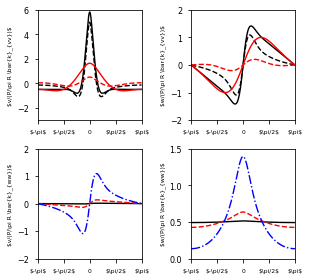

In [3]:
def s(x, asymm=False):
    if asymm:
        return np.append(-x, x[::-1])
    else:
        return np.append(x, x[::-1])

def t(x):
    return np.append(x-pi, x)

l_vv = 1000
l_ww = 10

tt = np.linspace(0, pi, 100)

with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(figsize=(4.4, 4), nrows=2, ncols=2)
    
    # Radial load
    ax[0, 0].plot(t(tt), -s(v_RT_rad(tt, 1000, 0.01*1000)), 'k', label='$\lambda_{vv}=1000$')
    ax[0, 0].plot(t(tt), -s(v_RT_rad(tt, 1000, 1.0*1000)), 'k--')
    
    ax[0, 0].plot(t(tt), -s(v_RT_rad(tt, 10, 0.01*100)), 'r', label='$\lambda_{vv}=100$')
    ax[0, 0].plot(t(tt), -s(v_RT_rad(tt, 10, 1.0*100)), 'r--')
    
    ax[0, 0].set_ylim([-3, 6])
    ax[0, 0].set_yticks([-2, 0, 2, 4, 6])
    ax[0, 0].set_ylabel(r'\$v/(P/\pi R \bar{k}_{vv})\$', fontsize=6)
    
    ax[0, 1].plot(t(tt), s(w_RT_rad(tt, 1000, 0.01*1000), asymm=True), 'k', label='$\lambda_{vv}=1000$')
    ax[0, 1].plot(t(tt), s(w_RT_rad(tt, 1000, 1.0*1000), asymm=True), 'k--')
    
    ax[0, 1].plot(t(tt), s(w_RT_rad(tt, 10, 0.01*100), asymm=True), 'r', label='$\lambda_{vv}=100$')
    ax[0, 1].plot(t(tt), s(w_RT_rad(tt, 10, 1.0*100), asymm=True), 'r--')
    
    ax[0, 1].set_yticks([-2, -1, 0, 1, 2])
    ax[0, 1].set_ylabel(r'\$w/(P/\pi R \bar{k}_{vv})\$', fontsize=6)
    
    # Tangential load
    ax[1, 0].plot(t(tt), s(v_RT_tan(tt, 1000, 0.01*1000), asymm=True), 'k', label='$\lambda_{ww} = 10$')
    ax[1, 0].plot(t(tt), s(v_RT_tan(tt, 1000, 0.1*1000), asymm=True), 'r--', label='$\lambda_{ww} = 100$')
    ax[1, 0].plot(t(tt), s(v_RT_tan(tt, 1000, 1.0*1000), asymm=True), 'b-.', label='$\lambda_{ww} = 1000$')
    
    ax[1, 0].set_yticks([-2, -1, 0, 1, 2])
    ax[1, 0].set_ylabel(r'\$v/(P/\pi R \bar{k}_{ww})\$', fontsize=6)
    
    ax[1, 1].plot(t(tt), s(w_RT_tan(tt, 1000, 0.01*1000)), 'k', label='$\lambda_{ww} = 10$')
    ax[1, 1].plot(t(tt), s(w_RT_tan(tt, 1000, 0.1*1000)), 'r--', label='$\lambda_{ww} = 100$')
    ax[1, 1].plot(t(tt), s(w_RT_tan(tt, 1000, 1.0*1000)), 'b-.', label='$\lambda_{ww} = 1000$')
    
    ax[1, 1].set_yticks([0, 0.5, 1, 1.5])
    ax[1, 1].set_ylabel(r'\$w/(P/\pi R \bar{k}_{ww})\$', fontsize=6)
    
    for a in ax.flatten():
        a.set_xlim([-pi, pi])
        a.set_xticks([-pi, -pi/2, 0, pi/2, pi])
        a.set_xticklabels([r'\$-\pi\$', r'\$-\pi/2\$','0', r'\$\pi/2\$', r'\$\pi\$'], fontsize=6)
    
    plt.tight_layout()
    plt.savefig('../figs/stress_analysis/_python_grid_radtan.pdf')
    plt.show()

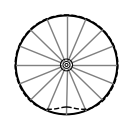

In [4]:
l_vv = 1000
l_ww = 1.

r_hub = 0.1

with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
    # Rim
    ax.add_artist(plt.Circle((0, 0), 1, fill=False, linewidth=2))
    # ax.add_artist(plt.Circle((0, 0), 0.97, fill=False, linewidth=1))
    
    # Hub
    ax.add_artist(plt.Circle((0, 0), 0.03, fill=False, linewidth=1))
    ax.add_artist(plt.Circle((0, 0), 0.07, fill=False, linewidth=1))
    ax.add_artist(plt.Circle((0, 0), 0.12, fill=False, linewidth=1, zorder=100))
    
    # Spokes (radial)
    for theta in np.arange(0, 2*pi, 2*pi/16):
        
        ax.plot([r_hub*cos(theta), cos(theta)],
                [r_hub*sin(theta), sin(theta)], '-', color='gray')
        
    # Deformed shape
    scale_fact_v = 0.15
    scale_fact_w = 0.15
    th = np.linspace(-pi, pi, 100)
    for l_vv, ls in zip([1000], ['k--']):
        r_def = 1.0 - scale_fact_v*(v_RT_rad(th, l_vv, l_ww) / v_RT_rad(pi, l_vv, l_ww))
        th_def = th + scale_fact_w*(w_RT_rad(th, l_vv, l_ww) / v_RT_rad(pi, l_vv, l_ww))/1.0
        ax.plot(r_def*cos(th_def+pi/2), r_def*sin(th_def+pi/2), ls)

    plt.savefig('../figs/stress_analysis/_python_wheel_def_rad.pdf')

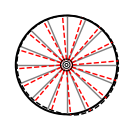

In [5]:
l_vv = 1000
l_ww = 1.

r_hub = 0.1
r_rim = 0.97

with plt.style.context(('seaborn-paper')):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
    # Rim
    ax.add_artist(plt.Circle((0, 0), 1, fill=False, linewidth=2))
    # ax.add_artist(plt.Circle((0, 0), 0.97, fill=False, linewidth=1))
    
    # Hub
    ax.add_artist(plt.Circle((0, 0), 0.03, fill=False, linewidth=1))
    ax.add_artist(plt.Circle((0, 0), 0.07, fill=False, linewidth=1))
    ax.add_artist(plt.Circle((0, 0), 0.12, fill=False, linewidth=1, zorder=100))
    
    # Spokes (radial)
    th_spk = np.arange(-pi, pi, 2*pi/16)
    r_spk = np.ones(th_spk.shape)
    for theta in th_spk:
        ax.plot([r_hub*cos(theta), r_rim*cos(theta)],
                [r_hub*sin(theta), r_rim*sin(theta)], '-', color='gray')
        
    # Deformed shape
    scale_fact_v = 15.0
    scale_fact_w = 0.0
    th = np.linspace(-pi, pi, 100)

    r_def = 1.0 - scale_fact_v*(v_RT_tan(th, l_vv, l_ww) / w_RT_tan(pi, l_vv, l_ww))

    th_def = th + scale_fact_w*(w_RT_tan(th, l_vv, l_ww) / w_RT_tan(pi, l_vv, l_ww))/1.0
    th_def = th_def - scale_fact_w*(w_RT_tan(0, l_vv, l_ww) / w_RT_tan(pi, l_vv, l_ww))/1.0

    ax.plot(r_def*cos(th_def+pi/2), r_def*sin(th_def+pi/2), 'k--')
    
    # Deformed spokes
    scale_fact_w = 0.08
    th_spk_def = th_spk + scale_fact_w*(w_RT_tan(th_spk, l_vv, l_ww) / w_RT_tan(pi, l_vv, l_ww))/1.0
    r_spk_def = 1.0 - scale_fact_v*(v_RT_tan(th_spk_def, l_vv, l_ww) / w_RT_tan(pi, l_vv, l_ww))
    
    for th_hub, th_rim, r_spk_def_i in zip(th_spk, th_spk_def, r_spk_def):
        ax.plot([r_hub*cos(th_hub+pi/2), r_spk_def_i*cos(th_rim+pi/2)],
                [r_hub*sin(th_hub+pi/2), r_spk_def_i*sin(th_rim+pi/2)], 'r--')

    plt.savefig('../figs/stress_analysis/_python_wheel_def_tan.pdf')